# Algorytmy macierzowe - zadanie nr 1 - Mnożenie macierzy

In [31]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pandas as pd

### Generowanie macierzy

In [2]:
def read_matrix(file_name):
    with open(file_name, 'r') as file:
        for line in file:
            if line.strip() == '':
                continue
            if line[0] == '#':
                if line[2:6] == "rows":
                    _, _, size = line.split()
                    size = int(size)
                    matrix = np.zeros((size, size))
            else:
                row, col, val = line.split(' ')
                matrix[int(row)-1, int(col)-1] = val
            
    return matrix

In [3]:
matrix_small = read_matrix("matrices/fem_1210_16x16.txt")
print(matrix_small)

[[0.11111111 0.05555556 0.         0.         0.05555556 0.02777778
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.05555556 0.11111111 0.         0.         0.02777778 0.05555556
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.11111111 0.05555556 0.         0.
  0.05555556 0.02777778 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.05555556 0.11111111 0.         0.
  0.02777778 0.05555556 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.05555556 0.02777778 0.         0.         0.11111111 0.05555556
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.02777778 0.05555556 0.         0.         0.05555556 0.11111111
  0.         0.         0.         0.         0.         0.
  0.         

### Procedura mnożenia macierzy

#### Klasyczna funkcja  w 6 wersjach

In [4]:
def mm_ijp(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for i in range(m):
        for j in range(k):
            for p in range(n):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_ipj(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for i in range(m):
        for p in range(n):
            for j in range(k):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_jip(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for j in range(k):
        for i in range(m):
            for p in range(n):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_jpi(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for j in range(k):
        for p in range(n):
            for i in range(m):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_pij(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for p in range(n):
        for i in range(m):
            for j in range(k):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_pji(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for p in range(n):
        for j in range(k):
            for i in range(m):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

In [5]:
def mm_test(matrix_a, matrix_b):
    matrix_c = matrix_a @ matrix_b
    res = True
    for mm in [mm_ijp, mm_ipj, mm_jip, mm_jpi, mm_pij, mm_pji]:
        if not np.allclose(matrix_c, mm(matrix_a, matrix_b)):
            print("{} not correct!".format(mm.__name__))
            res = False
    if res:
        print("OK")

mm_test(matrix_small, matrix_small)

OK


#### Procedura mnożenia blokowego macierzy

In [6]:
def mm_block(matrix_a, matrix_b, block_size):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k))
    
    for i in range(0, m, block_size):
        ib = min(m - i, block_size)
        for j in range(0, k, block_size):
            jb = min(n - j, block_size)
            for p in range(0, n, block_size):
                pb = min(k - p, block_size)
                matrix_c[i:i+ib, j:j+jb] += mm_ijp(matrix_a[i:i+ib, p:p+pb],
                                                                   matrix_b[p:p+pb, j:j+jb])
    return matrix_c

In [7]:
def mm_block_test(matrix_a, matrix_b):
    matrix_c = matrix_a @ matrix_b
    res = True
    for block_size in range(1, 20):
        if not np.allclose(matrix_c, mm_block(matrix_a, matrix_b, block_size)):
            print("{} incorrect block size!".format(block_size))
            res = False
    if res:
        print("OK")

mm_block_test(matrix_small, matrix_small)

OK


*1. Proszę wybrać dwie możliwie największe macierze A i B ze swoich dwóch rodzin macierzy, takie żeby zgadzały się ich rozmiary, oraz przemnożyć je A*B swoim optymalnym algorytmem (tak duże macierze jakie da się w czasie kilku-kilkudziesięciu minut przemnożyć na Państwa laptopie)*

In [12]:
matrix = read_matrix("matrices/fem_1420_81x81.txt")
print(matrix.shape)

(81, 81)


*2. Proszę narysować schemat niezerowych wartości swoich dwóch macierzy (używając komendy spy(A), spy(B) MATLABa) oraz macierzy wynikowej A*B*

### Pomiar czasów

*3. Proszę zmierzyć czas mnożenia tych wybranych dwóch dużych macierzy dla różnej kolejności pętli w algorytmie mnożenia macierzy. Proszę narysować tabelkę: kolejność pętli (6 możliwości) versus czasy mnożenia*

In [87]:
def compare_mult_times(matrix_a, matrix_b):
    times = {}
    for mm in [mm_ijp, mm_ipj, mm_jip, mm_jpi, mm_pij, mm_pji]:
        start = time()
        mm(matrix_a, matrix_b)
        times[mm.__name__[3:]] = time() - start
        
    df = pd.DataFrame(times.values(), times.keys(), ["times [s]"])
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlabel('loop order')
    ax.set_ylabel('multiplication time [s]')
    ax.bar(times.keys(), times.values(), color="#4a4e69")
    
    return df

,times [s]
ijp,0.236545
ipj,0.227300
jip,0.222225
jpi,0.222087
pij,0.230330
pji,0.237158


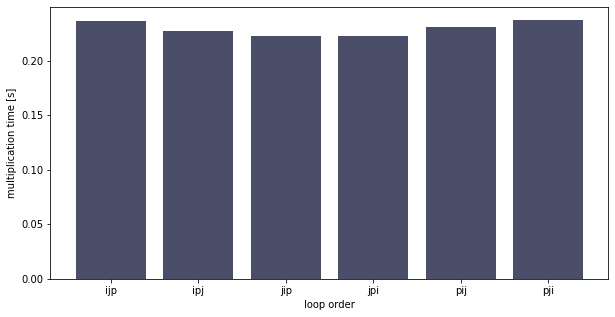

In [88]:
compare_mult_times(matrix, matrix)

*4. Proszę wybrać jedną kolejność pętli i następnie dla swoich dwóch macierzy A i B zmierzyć czasy mnożenia w algorytmie mnożenia blokowego. Proszę narysować wykres: oś x rozmiar bloków, oś y czas mnożenia*

In [ ]:
def compare_block_times(mat)

### Liczba operacji

*5. Proszę obliczyć liczbę operacji zmienno-przecinkowych koniecznych do*

### Wnioski